In [1]:
import pandas as pd
import numpy as np

from torch import Tensor
from torch import nn
import torch

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy

from sklearn.model_selection import train_test_split

In [2]:
def read_bedfile_tensor(f):
    return Tensor(pd.read_csv(f, index_col=0)['value_scaled'].values) 

### Set up data split

#### NOTE: This has to be corrected so that same patients don't end up on both train and test side

In [3]:
#train, test = train_test_split(DNAse_labels, random_state=100)
#train, val = train_test_split(train, random_state=100, test_size=0.1)

In [5]:
labels = pd.read_csv('./experiment_labels.csv')

In [ ]:
read_in_files = []
file_labels = labels['file_accession']
for f in file_labels:
    print(f)
    try:
        read_in_files.append(read_bedfile_tensor('./bed_files/'+f+'.bed'))
    except:
        print('Not found')

In [8]:
DNAse_labels = labels[labels['modality'] == 'DNase-seq']

In [9]:
train_ids, test_ids = train_test_split(DNAse_labels['subject_id'], random_state=100)
train_ids, val_ids = train_test_split(train_ids, random_state=100, test_size=0.1)

In [10]:
train_df = DNAse_labels[DNAse_labels['subject_id'].isin(train_ids)]
val_df = DNAse_labels[DNAse_labels['subject_id'].isin(val_ids)]
test_df = DNAse_labels[DNAse_labels['subject_id'].isin(test_ids)]

In [11]:
train_df['label'].value_counts()/len(train_df)

control    0.41875
AD         0.31875
MCI        0.23750
CI         0.02500
Name: label, dtype: float64

In [12]:
test_df['label'].value_counts()/len(test_df)

control    0.419753
AD         0.333333
MCI        0.148148
CI         0.098765
Name: label, dtype: float64

In [36]:
read_in_tensors = torch.stack([f for f in read_in_files if len(f)==2875012])
file_labels = [f for r, f in zip(read_in_files, file_labels) if len(r)==2875012]


binary_y = Tensor([t=='AD' for t in labels['label']]).float()
binary_labels = torch.stack([f for r, f in zip(read_in_files, binary_y) if len(r)==2875012])

## Train a simple classifier

### Set up convolutional model without feature selection

In [15]:
class EpiShift(nn.Module):
    """
    2 1D convolutions followed by a max pool
    
    Args:
        conv_stride:
        pool_stride:
    """
        
    def __init__(self, kernel_size=1000, conv_stride=5, 
                 pool_stride=5, dilation=2, embed_size=4302):
        super(EpiShift, self).__init__()
        
        self.CNN = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=1, stride=conv_stride, 
                      kernel_size=kernel_size, dilation=dilation, bias=False),
            nn.BatchNorm1d(1),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=1, out_channels=1, stride=conv_stride,
                      kernel_size=kernel_size, dilation=dilation, bias=False),
            nn.BatchNorm1d(1),
            nn.Conv1d(in_channels=1, out_channels=1, stride=conv_stride,
                      kernel_size=kernel_size, dilation=dilation, bias=False),
            nn.BatchNorm1d(1),
            nn.MaxPool1d(kernel_size=kernel_size, stride=pool_stride, padding=0, 
                         dilation=1)
        )
        
        self.fc1 = nn.Linear(embed_size, 1)
        
    def forward(self, data: Tensor):
        
        embed = self.CNN(data)
        x = self.fc1(embed)
        return x

    
# Just logistic regression
class LogisticReg(nn.Module):
    """
    2 1D convolutions followed by a max pool
    
    Args:
        conv_stride:
        pool_stride:
    """
        
    def __init__(self, input_size):
        super(LogisticReg, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 1)
        
    def forward(self, data: Tensor):
        
        x = self.fc1(data)
        return x
    
    
# Autoencoder block  
def full_block(in_features, out_features, p_drop):
        return nn.Sequential(
            nn.Linear(in_features, out_features, bias=True),
            nn.LayerNorm(out_features),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        )

class FullNet(nn.Module):
    '''
    '''
    def __init__(self, x_dim, hid_dim=128, z_dim=64, p_drop=0):
        super(FullNet, self).__init__()
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            full_block(x_dim, hid_dim, p_drop),
            full_block(hid_dim, z_dim, p_drop),
        )
        
        self.decoder = nn.Sequential(
            full_block(z_dim, hid_dim, p_drop),
            full_block(hid_dim, x_dim, p_drop),
        )
      
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded


### EpiShift trainer

In [16]:
device = 'cuda:8'

In [17]:
from torch.utils.data import DataLoader

class DNAse_Dataset(torch.utils.data.Dataset):
    def __init__(self, track, labels):
        'Initialization'
        self.tracks = track
        self.labels = labels
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.tracks[index], self.labels[index]

In [23]:
train_idx = np.where([f in train_df['file_accession'].values for f in file_labels])[0]
val_idx = np.where([f in val_df['file_accession'].values for f in file_labels])[0]
test_idx = np.where([f in test_df['file_accession'].values for f in file_labels])[0]

In [37]:
# Create dataloader
train_dataset = DNAse_Dataset(read_in_tensors[train_idx], binary_labels[train_idx])
val_dataset = DNAse_Dataset(read_in_tensors[val_idx], binary_labels[val_idx])
test_dataset = DNAse_Dataset(read_in_tensors[test_idx], binary_labels[test_idx])

train_dataloader = DataLoader(train_dataset, batch_size=20)
val_dataloader = DataLoader(val_dataset, batch_size=20)
test_dataloader = DataLoader(test_dataset, batch_size=20)

In [48]:
## Trainer
model = EpiShift()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, 
                       weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=1, 
#                   gamma=0.5)
min_val_loss = np.inf
m = nn.Sigmoid()
best_model = deepcopy(model)
model.train()
model.to(device)
losses = []
val_losses = []

for epoch in range(30):
    print(epoch)
    model.train()
    
    # Training epoch
    for step, data in enumerate(train_dataloader):
        X = data[0].to(device)
        y = data[1].to(device)
        optimizer.zero_grad()

        pred = model(X.unsqueeze(1))
        loss = criterion(m(pred).squeeze(), y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
        print("Training Loss:", loss.detach().cpu().numpy())

    # Validation step
    val_loss_sum = 0
    model.eval()
    for step, data in enumerate(val_dataloader):
        X = data[0].to(device)
        y = data[1].to(device)

        val_pred = model(X.unsqueeze(1))
        val_loss = criterion(m(val_pred).squeeze(), y)
        val_loss_sum += val_loss
        
    print("Validation Loss:", val_loss_sum.detach().cpu().numpy())
    if val_loss_sum > min_val_loss:
        min_val_loss = val_loss_sum
        best_model = deepcopy(model)

0
Training Loss: 0.83696586
Training Loss: 0.8512673
Training Loss: 1.3063523
Training Loss: 0.82901853
Training Loss: 1.2802312
Training Loss: 1.4568272
Training Loss: 1.1480544
Validation Loss: 1.0571274
1
Training Loss: 0.98301995
Training Loss: 0.70448595
Training Loss: 0.75097555
Training Loss: 1.0437144
Training Loss: 1.14103
Training Loss: 0.97941
Training Loss: 0.8278078
Validation Loss: 1.617341
2
Training Loss: 0.6914822
Training Loss: 0.654645
Training Loss: 0.6761734
Training Loss: 0.55688155
Training Loss: 0.60046774
Training Loss: 0.9573183
Training Loss: 1.0409454
Validation Loss: 0.9265917
3
Training Loss: 0.919652
Training Loss: 0.7071683
Training Loss: 0.6904067
Training Loss: 0.61311495
Training Loss: 0.6246263
Training Loss: 0.70438874
Training Loss: 0.7101474
Validation Loss: 1.5077192
4
Training Loss: 0.6699446
Training Loss: 0.6654951
Training Loss: 0.6942784
Training Loss: 0.70491755
Training Loss: 0.6030583
Training Loss: 0.74071276
Training Loss: 0.79383296
Va

In [64]:
test_preds = []
ys = []
model.eval()

for step, data in enumerate(test_dataloader):
    X = data[0].to(device)
    y = data[1].to(device)

    test_pred = model(X.unsqueeze(1))
    tp = test_pred.squeeze().cpu().detach().numpy()
    test_preds.extend(tp)
    ys.extend(y.cpu().detach().numpy())

In [ ]:
[t.cpu().detach().numpy().flatten() for t in test_preds]

In [69]:
from sklearn.metrics import roc_curve

In [71]:
fpr, tpr, thresholds = roc_curve(ys, test_preds)

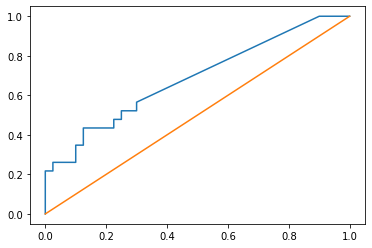

In [74]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

### EpiMap data download script

In [4]:
template1 = 'wget https://epigenome.wustl.edu/epimap/data/observed/FINAL_DNase-seq_BSS'
template2 = '.sub_VS_Uniform_BKG_CONTROL_36_50000000.pval.signal.bedgraph.gz.bigWig'

In [5]:
with open('./EpiMap/dl_script2.txt', 'a') as out_file:
    for number in range(10,999):
        file_num = "{:05d}".format(number)
        filename = template1 + file_num + template2
        out_file.write(filename+'\n')